In [1]:
# Data Frame
import pandas as pd
import xarray as xr

# Algorithm
import numpy as np
from scipy.sparse.csgraph import shortest_path

# Visualization
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

# Data Frames and Unit Conversion

In [2]:
FL_to_hPa = {100 : 600, 120 : 600, 140 : 600, 160 : 550, 180 : 500, 
             200 : 450, 220 : 450, 240 : 400, 260 : 350, 280 : 350, 
             300 : 300, 320 : 300, 340 : 250, 360 : 225, 380 : 200,
             400 : 200}

In [3]:
# Flight starting and end points
flights = pd.read_excel('data/flights.xlsx')
flights.head()

,flight_number,start_time,start_flightlevel,start_longitudinal,start_latitudinal,end_longitudinal,end_latitudinal
0,0,07:15:00,250,-30,56,24,60
1,1,07:10:00,310,-30,56,30,42
2,2,07:50:00,250,-22,34,30,46
3,3,07:30:00,260,-26,34,28,60
4,4,07:00:00,230,-30,42,30,46


In [4]:
# Flight speed and fuel cost
bada_data = pd.read_excel('data/bada_data.xlsx')
# Trim unnecessary data
trimmed_bada_data = bada_data[9:25].copy().reset_index()
trimmed_bada_data.pop("index")
trimmed_bada_data["LEVEL11_24"] = trimmed_bada_data["FL"].map(FL_to_hPa)
trimmed_bada_data

,FL,CRUISE TAS [kts],CRUISE fuel [kg/min],CLIMB TAS [kts],CLIMB ROC [ft/min],CLIMB fuel [kg/min],DESCENT TAS [kts],DESCENT ROD [ft/min],DESCENT fuel [kg/min],LEVEL11_24
0,100,289.0,40.3,289,2750,104.1,289,1680,8.4,600
1,120,356.0,47.8,356,2670,99.4,356,2310,8.1,600
2,140,366.0,47.6,366,2490,94.6,366,2340,7.9,600
3,160,377.0,47.5,377,2310,89.8,377,2370,7.7,550
4,180,388.0,47.3,388,2130,85.1,388,2400,7.5,500
5,200,400.0,47.1,400,1940,80.5,400,2740,7.3,450
6,220,412.0,46.9,412,1740,76.0,412,2760,7.1,450
7,240,425.0,46.6,425,1550,71.6,425,2770,6.9,400
8,260,438.0,46.4,438,1350,67.2,438,2780,6.7,350
9,280,452.0,46.1,452,1150,62.9,452,2790,6.5,350


In [5]:
# Warming or Cooling effect
ds = xr.open_dataset('data/aCCF_0623_p_spec.nc')
df = ds.to_dataframe()
merged = df["MERGED"].to_frame()
# Trim unnecessary data
trimmed_merged = merged.iloc[(df.index.get_level_values('LONGITUDE') <= 30) & 
                       (df.index.get_level_values('LONGITUDE') >= -30) &
                       (df.index.get_level_values('LEVEL11_24') >= 200) & 
                       (df.index.get_level_values('bnds') == 0)]
trimmed_merged = trimmed_merged.reset_index()
trimmed_merged.pop("bnds")
trimmed_merged.head()

,LONGITUDE,LATITUDE,LEVEL11_24,TIME,MERGED
0,-30.0,34.0,200,2018-06-23 06:00:00,0.088344
1,-30.0,34.0,200,2018-06-23 12:00:00,0.088190
2,-30.0,34.0,200,2018-06-23 18:00:00,0.088036
3,-30.0,34.0,225,2018-06-23 06:00:00,0.084318
4,-30.0,34.0,225,2018-06-23 12:00:00,0.084189


# Parameterization of Voxels

In [6]:
def ijk_exist(i, j, k):
    """
    i is the parameter for longitude, 
    0 <= i <= 30 corresponds to -30 <= longitude <= 30 (30°W to 30°E).
    
    j is the parameter for latitude, 
    0 <= j <= 13 corresponds to 34 <= latitude <= 60 (34°N to 60°N).
    
    k is the parameter for flight level, 
    0 <= k <= 15 corresponds to 100 <= flight level <= 400 (100 FL to 400 FL).
    """
    return not (i > 30 or j > 13 or k > 15 or i < 0 or j < 0 or k < 0)

def get_point_from_ijk(i, j, k):
    """
    A point consists of (longitude, latitude, flight level).
    
    >>> get_point_from_ijk(0, 0, 0)
    (-30, 34, 100)
    """
    if not ijk_exist(i, j, k):
        raise ValueError("This ijk does not exist")
    long = -30 + 2 * i
    lat = 34 + 2 * j
    fl = 100 + 20 * k
    return long, lat, fl

def get_ijk_from_point(long, lat, fl):
    if (long >= 31 or long <= -31) or (lat >= 61 or lat <= 33) or (fl >= 410 or fl <= 90):
        raise ValueError("No Point on Map")
    i = int(np.round((long + 30) / 2))
    j = int(np.round((lat - 34) / 2))
    k = int(np.round((fl - 100) / 20))
    return i, j, k

def get_voxel_from_ijk(i, j, k):
    """
    >>> get_voxel_from_ijk(0, 0, 1)
    0
    >>> get_voxel_from_ijk(0, 0, 1)
    434
    """
    if not ijk_exist(i, j, k):
        raise ValueError("This ijk does not exist")
    return 31 * 14 * k + 31 * j + i

def get_ijk_from_voxel(voxel):
    if voxel > 6943 or voxel < 0:
        raise ValueError("Not a voxel index")
    i = voxel % 31
    j = voxel % (31 * 14) // 31
    k = voxel // (31 * 14)
    return i, j, k

def get_point_from_voxel(voxel):
    i, j, k = get_ijk_from_voxel(voxel)
    return get_point_from_ijk(i, j, k)

def get_voxel_from_point(long, lat, fl):
    i, j, k = get_ijk_from_point(long, lat, fl)
    return get_voxel_from_ijk(i, j, k)

def get_neighbor_voxels_26(voxel):
    """
    Diagonal voxels also count as neighbors.
    There are at most 26 neighbors for a voxel.
    
    >>> get_neighbor_voxels_26(0)
    [1, 31, 32, 434, 435, 465, 466]
    """
    neighbors = []
    i, j, k = get_ijk_from_voxel(voxel)
    for del_k in range(-1, 2):
        for del_j in range(-1, 2):
            for del_i in range(-1, 2):
                new_i, new_j, new_k = i + del_i, j + del_j, k + del_k
                if ijk_exist(new_i, new_j, new_k) and voxel != get_voxel_from_ijk(new_i, new_j, new_k):
                    neighbors.append(get_voxel_from_ijk(new_i, new_j, new_k))
    return neighbors

# Functions for Getting Speed, Costs, and Distances

In [7]:
def get_speed_voxel_km_min(voxel, elevation):
    """
    Return true air speed in km/min of the airplane at a give VOXEL
    and ELEVATION (could be "CRUISE", "CLIMB", or "DESCENT").
    """
    long, lat, fl = get_point_from_voxel(voxel)
    return trimmed_bada_data.loc[trimmed_bada_data['FL']==fl, elevation +  " TAS [kts]"].values[0] * 1.852 / 60

def get_ROCD_voxel_km(voxel, elevation):
    """
    Return rate of climbing (ROC) or rate of descenting (ROD) in km/min
    of the airplane at a give VOXEL and ELEVATION (could be "CLIMB", or "DESCENT").
    """
    long, lat, fl = get_point_from_voxel(voxel)
    if elevation == "CLIMB":
        return trimmed_bada_data.loc[trimmed_bada_data['FL']==fl, "CLIMB ROC [ft/min]"].values[0] * 0.0003048
    elif elevation == "DESCENT":
        return trimmed_bada_data.loc[trimmed_bada_data['FL']==fl, "DESCENT ROD [ft/min]"].values[0] * 0.0003048

def get_delta_C_per_min_voxel(voxel, elevation, time):
    """
    Return the warming or cooling effect (delta C) in Kelvin/min of the airplane 
    at a give VOXEL, ELEVATION (could be "CRUISE", "CLIMB", or "DESCENT"),
    and time (could be "2018-06-23 06:00:00", "2018-06-23 12:00:00",
    or "2018-06-23 18:00:00").
    
    >>> np.round(get_delta_C_per_min_voxel(0, "CRUISE", "2018-06-23 06:00:00"), 2)
    5.11
    """
    long, lat, fl = get_point_from_voxel(voxel)
    hPa = FL_to_hPa[fl]
    
    kg_fule_min = trimmed_bada_data.loc[trimmed_bada_data['FL']==fl, elevation +  " fuel [kg/min]"].values[0]
    delta_C_per_fule_kg = trimmed_merged.loc[(trimmed_merged['LONGITUDE']==long) & 
                                             (trimmed_merged['LATITUDE']==lat) &
                                             (trimmed_merged['LEVEL11_24']==hPa) &
                                             (trimmed_merged['TIME']==time)]["MERGED"].values[0]
    return delta_C_per_fule_kg * kg_fule_min

def get_distance_km(voxel1, voxel2):
    """
    Returns horizontal distance and altitudinal (flight level) difference in km
    """
    i1, j1, k1 = get_ijk_from_voxel(voxel1)
    i2, j2, k2 = get_ijk_from_voxel(voxel2)
    long_diff_km = (i2 - i1) * 85 * 2
    lat_diff_km = (j2 - j1) * 111 * 2
    fl_diff_km = (k2 - k1) * 2000 * 0.3048 / 1000
    return np.sqrt(long_diff_km ** 2 + lat_diff_km ** 2), fl_diff_km

# Get Path Weights (Weight Matrices for Shortest Path Calculation)

In [8]:
def get_weight_time(voxel1, voxel2, time):
    """
    Returns delta C (or weight of the path, unit in Kelvin) for moving from the 
    center of VOXEL1 to the center of VOXEL2 at given TIME (e.g. "2018-06-23 06:00:00"). 
    Also returns the amount of time the airplane stays in VOXEL1 (time1) and VOXEL2 (time2).
    """
    hor_dist, fl_diff = get_distance_km(voxel1, voxel2)
    if fl_diff == 0:
        time1 = hor_dist / 2 / get_speed_voxel_km_min(voxel1, "CRUISE")
        time2 = hor_dist / 2 / get_speed_voxel_km_min(voxel2, "CRUISE")
        delta_C = get_delta_C_per_min_voxel(voxel1, "CRUISE", time) * time1 + \
                  get_delta_C_per_min_voxel(voxel2, "CRUISE", time) * time2
    elif fl_diff > 0:
        # in voxel1
        roc1 = get_ROCD_voxel_km(voxel1, "CLIMB")
        tas_climb1 = get_speed_voxel_km_min(voxel1, "CLIMB")
        tas_cruise1 = get_speed_voxel_km_min(voxel1, "CRUISE")
        time_climb1 = fl_diff / 2 / roc1
        if hor_dist == 0:
            time_cruise1 = 0
        else:
            time_cruise1 = (hor_dist / 2 - tas_climb1 * time_climb1) / tas_cruise1
        time1 = time_climb1 + time_cruise1
        # in voxel2
        roc2 = get_ROCD_voxel_km(voxel2, "CLIMB")
        tas_climb2 = get_speed_voxel_km_min(voxel2, "CLIMB")
        tas_cruise2 = get_speed_voxel_km_min(voxel2, "CRUISE")
        time_climb2 = fl_diff / 2 / roc2
        if hor_dist == 0:
            time_cruise2 = 0
        else:
            time_cruise2 = (hor_dist / 2 - tas_climb2 * time_climb2) / tas_cruise2
        time2 = time_climb2 + time_cruise2
        # weight
        delta_C = get_delta_C_per_min_voxel(voxel1, "CLIMB", time) * time_climb1 + \
                  get_delta_C_per_min_voxel(voxel1, "CRUISE", time) * time_cruise1 + \
                  get_delta_C_per_min_voxel(voxel2, "CLIMB", time) * time_climb2 + \
                  get_delta_C_per_min_voxel(voxel2, "CRUISE", time) * time_cruise2
    else:
        fl_diff = abs(fl_diff)
        # in voxel1
        rod1 = get_ROCD_voxel_km(voxel1, "DESCENT")
        tas_descent1 = get_speed_voxel_km_min(voxel1, "DESCENT")
        tas_cruise1 = get_speed_voxel_km_min(voxel1, "CRUISE")
        time_descent1 = fl_diff / 2 / rod1
        if hor_dist == 0:
            time_cruise1 = 0
        else:
            time_cruise1 = (hor_dist / 2 - tas_descent1 * time_descent1) / tas_cruise1
        time1 = time_descent1 + time_cruise1
        # in voxel2
        rod2 = get_ROCD_voxel_km(voxel2, "DESCENT")
        tas_descent2 = get_speed_voxel_km_min(voxel2, "DESCENT")
        tas_cruise2 = get_speed_voxel_km_min(voxel2, "CRUISE")
        time_descent2 = fl_diff / 2 / rod2
        if hor_dist == 0:
            time_cruise2 = 0
        else:
            time_cruise2 = (hor_dist / 2 - tas_descent2 * time_descent2) / tas_cruise2
        time2 = time_descent2 + time_cruise2
        # weight
        delta_C = get_delta_C_per_min_voxel(voxel1, "DESCENT", time) * time_descent1 + \
                  get_delta_C_per_min_voxel(voxel1, "CRUISE", time) * time_cruise1 + \
                  get_delta_C_per_min_voxel(voxel2, "DESCENT", time) * time_descent2 + \
                  get_delta_C_per_min_voxel(voxel2, "CRUISE", time) * time_cruise2
    return delta_C, time1, time2

In [9]:
# Initialize all elements of weight and time matrices to infinity
voxel_count = 31 * 14 * 16
weight_matrix_26_neighbors_6am = np.ones((voxel_count, voxel_count)) * np.inf
weight_matrix_26_neighbors_12pm = np.ones((voxel_count, voxel_count)) * np.inf
weight_matrix_26_neighbors_6pm = np.ones((voxel_count, voxel_count)) * np.inf
time_matrix_26_neighbors = np.ones((voxel_count, voxel_count)) * np.inf

In [10]:
# Fill in the path weights and time for our shortest path algorithm
for voxel1 in range(voxel_count):
    neighbors = get_neighbor_voxels_26(voxel1)
    for voxel2 in neighbors:
        weight_matrix_26_neighbors_6am[voxel1][voxel2], time1, time2 = get_weight_time(voxel1, voxel2, "2018-06-23 06:00:00")
        weight_matrix_26_neighbors_12pm[voxel1][voxel2], time1, time2 = get_weight_time(voxel1, voxel2, "2018-06-23 12:00:00")
        weight_matrix_26_neighbors_6pm[voxel1][voxel2], time1, time2 = get_weight_time(voxel1, voxel2, "2018-06-23 18:00:00")
        time_matrix_26_neighbors[voxel1][voxel2] = time1 + time2

In [11]:
# Avoid negative cycles (for shortest path algorithms to work) in the weight matrices
# by adding constant positive values.
# Real costs of flights will still be calculated using the original weight matrices

# For 6am weight matrix
min_weight_6am = 0
for i in range(voxel_count):
    for j in range(voxel_count):
        weight = weight_matrix_26_neighbors_6am[i][j]
        if weight < 0 and weight < min_weight_6am:
            min_weight_6am = weight
weight_matrix_26_neighbors_6am_no_negative = weight_matrix_26_neighbors_6am.copy()
for i in range(voxel_count):
    for j in range(voxel_count):
        weight = weight_matrix_26_neighbors_6am_no_negative[i][j]
        if weight != np.inf:
            weight_matrix_26_neighbors_6am_no_negative[i][j] -= min_weight_6am
            
# For 12pm weight matrix
min_weight_12pm = 0
for i in range(voxel_count):
    for j in range(voxel_count):
        weight = weight_matrix_26_neighbors_12pm[i][j]
        if weight < 0 and weight < min_weight_12pm:
            min_weight_12pm = weight
weight_matrix_26_neighbors_12pm_no_negative = weight_matrix_26_neighbors_12pm.copy()
for i in range(voxel_count):
    for j in range(voxel_count):
        weight = weight_matrix_26_neighbors_12pm_no_negative[i][j]
        if weight != np.inf:
            weight_matrix_26_neighbors_12pm_no_negative[i][j] -= min_weight_12pm
            
# For 6pm weight matrix
min_weight_6pm = 0
for i in range(voxel_count):
    for j in range(voxel_count):
        weight = weight_matrix_26_neighbors_6pm[i][j]
        if weight < 0 and weight < min_weight_6pm:
            min_weight_6pm = weight
weight_matrix_26_neighbors_6pm_no_negative = weight_matrix_26_neighbors_6pm.copy()
for i in range(voxel_count):
    for j in range(voxel_count):
        weight = weight_matrix_26_neighbors_6pm_no_negative[i][j]
        if weight != np.inf:
            weight_matrix_26_neighbors_6pm_no_negative[i][j] -= min_weight_6pm

# Calculate Shortest Path and Some Tools for Path

In [12]:
# Check out `scipy.sparse.csgraph.shortest_path` and Dijkstra’s algorithm
dist_matrix_6am, predecessors_6am = shortest_path(csgraph=weight_matrix_26_neighbors_6am_no_negative, 
                                                  directed=True, return_predecessors=True, method="D")
dist_matrix_12pm, predecessors_12pm = shortest_path(csgraph=weight_matrix_26_neighbors_12pm_no_negative, 
                                                    directed=True, return_predecessors=True, method="D")
dist_matrix_6pm, predecessors_6pm = shortest_path(csgraph=weight_matrix_26_neighbors_6pm_no_negative, 
                                                    directed=True, return_predecessors=True, method="D")

In [13]:
def get_path(Pr, i, j):
    """
    Return shortest path from initial point I to target point J
    using predecessor matrix Pr.
    """
    path = [j]
    k = j
    while Pr[i, k] != -9999:
        path.append(Pr[i, k])
        k = Pr[i, k]
    return path[::-1]

def get_delta_C_from_path(path, weight_matrix):
    """
    Return the cost (unit in Kelvin) given the PATH and WEIGHT_MATRIX.
    """
    delta_C_total = 0
    for i in range(len(path) - 1):
        delta_C_total += weight_matrix[path[i]][path[i+1]]
    return delta_C_total

def get_time_from_path(path, time_matrix):
    """
    Return the time (unit in min) given the PATH and TIME_MATRIX.
    """
    total_time = 0
    for i in range(len(path) - 1):
        total_time += time_matrix[path[i]][path[i+1]]
    return total_time

# Flight Cost and Trajectories Calculation

In [14]:
def min_to_time(minutes, date=False):
    """
    >>> min_to_time(0, date=True)
    "2018-06-23 06:00:00"
    >>> min_to_time(0)
    "06:00:00"
    """
    hour = int(minutes // 60 + 6)
    minute = int(minutes % 60 // 1)
    second = int((minutes - (hour - 6) * 60 - minute) * 60)
    if hour < 10:
        hour = "0" + str(hour)
    else:
        hour = str(hour)
    if minute < 10:
        minute = "0" + str(minute)
    else:
        minute = str(minute)
    if second < 10:
        second = "0" + str(second)
    else:
        second = str(second)
    if date:
        return "2018-06-23 " + hour + ":" + minute + ":" + second
    else:
        return hour + ":" + minute + ":" + second

In [15]:
def time_to_min(time):
    """
    >>> time_to_min("2018-06-23 06:00:00")
    0
    >>> time_to_min("07:00:00")
    60
    """
    hour = int(time[-8:-6]) - 6
    minute = int(time[-5:-3])
    second = int(time[-2:])
    return hour * 60 + minute + second / 60

In [16]:
def get_delta_C_traj(start_time, start_voxel, end_long, end_lat, weight_matrix, time_matrix, predecessors):
    """
    Return the cost by constructing trajectories from the given parameters. 
    A helper function of `get_delta_C_traj_one_flight`.
    """
    min_delta_C = np.inf
    min_path = []
    for i in range(100, 420, 20):
        end_voxel = get_voxel_from_point(end_long, end_lat, i)
        path = get_path(predecessors, start_voxel, end_voxel)
        delta_C = get_delta_C_from_path(path, weight_matrix)
        if delta_C < min_delta_C:
            min_delta_C = delta_C
            min_path = path
    time = start_time
    traj = [[time, min_path[0]]] # minute, voxel
    for i in range(len(min_path) - 1):
        time += time_matrix[min_path[i]][min_path[i+1]]
        traj.append([time, min_path[i+1]])
    return min_delta_C, traj

def get_delta_C_traj_one_flight(flight_number):
    """
    Return the cost of a flight with consideration of time difference (use 
    different weight matrix or equivalently predecessors matrix) for 
    finding the shortest trajectory.
    """
    # 6 AM
    data = flights.loc[flight_number]
    start_time, start_fl, start_long, start_lat, end_long, end_lat = data[1], data[2], data[3], data[4], data[5], data[6]
    start_time = time_to_min(start_time)
    start_voxel = get_voxel_from_point(start_long, start_lat, start_fl)
    min_delta_C_6am, traj_6am = get_delta_C_traj(start_time, start_voxel, 
                                                 end_long, end_lat, 
                                                 weight_matrix_26_neighbors_6am, 
                                                 time_matrix_26_neighbors, predecessors_6am)
    if traj_6am[-1][0] < 180:
        # print("Flight ended before 9 AM")
        return min_delta_C_6am, traj_6am
    for i, (time, voxel) in enumerate(traj_6am):
        if time >= 180:
            traj_6am = traj_6am[:i]
            path_6am = [voxel for _, voxel in traj_6am]
            min_delta_C_6am = get_delta_C_from_path(path_6am, weight_matrix_26_neighbors_6am)
            break
    # 12 PM
    start_time = traj_6am[-1][0]
    start_voxel = traj_6am[-1][1]
    min_delta_C_12pm, traj_12pm = get_delta_C_traj(start_time, start_voxel, 
                                                   end_long, end_lat, 
                                                   weight_matrix_26_neighbors_12pm, 
                                                   time_matrix_26_neighbors, predecessors_12pm)
    traj_12pm = traj_12pm[1:]
    if traj_12pm[-1][0] < 540:
        # print("Flight ended before 3 PM")
        return min_delta_C_6am + min_delta_C_12pm, traj_6am + traj_12pm
    for i, (time, voxel) in enumerate(traj_12pm):
        if time >= 540:
            traj_12pm = traj_12pm[:i]
            path_12pm = [voxel for _, voxel in traj_12pm]
            min_delta_C_12pm = get_delta_C_from_path(path_12pm, weight_matrix_26_neighbors_12pm)
            break
    # 6 PM
    start_time = traj_12pm[-1][0]
    start_voxel = traj_12pm[-1][1]
    min_delta_C_6pm, traj_6pm = get_delta_C_traj(start_time, start_voxel, 
                                                 end_long, end_lat, 
                                                 weight_matrix_26_neighbors_6pm, 
                                                 time_matrix_26_neighbors, predecessors_6pm)
    traj_6pm = traj_6pm[1:]
    # print("Flight ended after 3 PM")
    return min_delta_C_6am + min_delta_C_12pm + min_delta_C_6pm, traj_6am + traj_12pm + traj_6pm

def get_delta_C_traj_flights():
    """
    Return the cost for all 100 flights by calling 
    `get_delta_C_traj_one_flight` for each flight.
    """
    total_delta_C = 0
    trajs = []
    for i in range(100):
        delta_C, traj = get_delta_C_traj_one_flight(i)
        total_delta_C += delta_C
        trajs.append(traj)
    return total_delta_C, trajs

In [17]:
total_delta_C, trajs = get_delta_C_traj_flights()
print("Total Cost for 100 Flights:", total_delta_C, "* 10^-12 K")

Total Cost for 100 Flights: 113039.58067816428 * 10^-12 K


# Check if there are Collisions 

In [18]:
def get_column_from_voxel(voxel):
    """
    Return a list of voxel that has the same longitude and latitude.
    """
    long, lat, fl = get_point_from_voxel(voxel)
    return [get_voxel_from_point(long, lat, FL) for FL in range(100, 401, 20)]

In [19]:
def check_collisions_columns_index(traj1, traj2):
    """
    Return the indices of where the trajectories TRAJ1 and TRAJ2 collide.
    For example, if TRAJ1[2] collides with TRAJ2[6] and TRAJ1[3] collides with TRAJ2[7],
    the function returns [(2, 6), (3, 7)].
    
    A collision means that the flights are in the same voxel column and have a 
    distance smaller than 5 NM (9.26 km) given by the trajectories.
    """
    collision_index = []
    for i, (time_1, voxel_1) in enumerate(traj1):
        for j, (time_2, voxel_2) in enumerate(traj2):
            if voxel_1 in get_column_from_voxel(voxel_2):
                if time_1 == time_2:
                    collision_index.append((i, j))
                elif time_1 > time_2:
                    if j < len(traj2) - 1 and traj2[j+1][0] > time_1:
                        time_diff = time_1 - time_2
                        speed = get_speed_voxel_km_min(voxel_1, "CRUISE")
                        if speed * time_diff < 9.26:
                            collision_index.append((i, j))
                else:
                    if i < len(traj1) - 1 and traj1[i+1][0] > time_2:
                        time_diff = time_2 - time_1
                        speed = get_speed_voxel_km_min(voxel_1, "CRUISE")
                        if speed * time_diff < 9.26:
                            collision_index.append((i, j))
    return collision_index

In [20]:
collision_index_dict = {}

collisions = 0
for i in range(100):
    for j in range(i+1, 100):
        list_of_collisions = check_collisions_columns_index(trajs[i], trajs[j])
        if list_of_collisions:
            print(i, j)
            print(list_of_collisions)
            collision_index_dict[(i, j)] = list_of_collisions
            collisions += 1
            print("--------------------------------------")
print("The number of collisions (a flight colliding with multiple flights also counts):", collisions)

0 94
[(2, 6)]
--------------------------------------
1 28
[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16)]
--------------------------------------
1 63
[(0, 3)]
--------------------------------------
2 37
[(11, 15), (12, 16), (13, 17), (14, 18), (15, 19), (16, 20), (17, 21), (18, 22), (19, 23), (20, 24), (21, 25), (22, 26), (23, 27), (24, 28), (25, 29)]
--------------------------------------
2 40
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (10, 10), (11, 11)]
--------------------------------------
4 53
[(6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26)]
--------------------------------------
6 36
[(0, 0)]
--------------------------------------
8 57
[(2, 1)]
--------------------------------------
12 51
[(0, 0), (1, 1)]
--------------------------------------
1

# Resolve Collisions

In [21]:
def get_hor_direction(point1, point2):
    """
    Return the x-y (long-lat) direction (vector) from point1 to point2.
    
    >>> get_hor_direction((-30, 34, 100), (-28, 34, 100))
    (2, 0)
    """
    return (point2[0] - point1[0], point2[1] - point1[1])

def get_left_right(direction, left=True):
    """
    Return the normalized left (or right) of the given DIRECTION.
    """
    norm = np.linalg.norm(direction)
    if left:
        return (-direction[1] / norm, direction[0]/ norm)
    return (direction[1] / norm, -direction[0] / norm)

In [22]:
def voxel_traj_to_points(traj):
    """
    TRAJ records locations using voxels. Return an alternative (point_traj) of TRAJ 
    by recording locations by points (long, lat, fl).
    """
    point_traj = []
    for time, voxel in traj:
        point_traj.append([time, get_point_from_voxel(voxel)])
    return point_traj

In [23]:
point_trajs_with_collisions = [voxel_traj_to_points(traj) for traj in trajs]
point_trajs = [voxel_traj_to_points(traj) for traj in trajs]

In [24]:
def resolve_one_collision(i, j):
    """
    Return the non-colliding point trajectories. 
    I and J are the flight numbers.
    """
    point_traj1, point_traj2 = point_trajs[i], point_trajs[j]
    if (i, j) not in collision_index_dict.keys():
        print("No collision or flight index i is larger than j")
        return point_traj1, point_traj2
    collision_index = collision_index_dict[(i, j)]
    for col_index1, col_index2 in collision_index:
        point_1 = point_traj1[col_index1][1]
        point_2 = point_traj2[col_index2][1]
        voxel_1 = get_voxel_from_point(point_1[0], point_1[1], point_1[2]) 
        voxel_2 = get_voxel_from_point(point_2[0], point_2[1], point_2[2]) 
        if point_1 != get_point_from_voxel(voxel_1) or point_2 != get_point_from_voxel(voxel_2):
            # collision has already been resolved in this voxel
            break
        else:
            if col_index1 == 0:
                direction_1 = get_hor_direction(point_1, point_traj1[col_index1+1][1])
            else:
                direction_1 = get_hor_direction(point_traj1[col_index1-1][1], point_1)
            if col_index2 == 0:
                direction_2 = get_hor_direction(point_2, point_traj2[col_index2+1][1])
            else:
                direction_2 = get_hor_direction(point_traj2[col_index2-1][1], point_2)
            if direction_1 == (0, 0):
                direction_1 = direction_2
            elif direction_2 == (0, 0):
                direction_2 = direction_1
            if direction_1 == (0, 0) and direction_2 == (0, 0):
                direction_1 = (1, 1)
            direction_2 = direction_1
            # move flight i to the left of its direction by 10 km in voxel_1
            # (so that it's greater than 5 NM or 9.26 km)
            left = get_left_right(direction_1)
            right = get_left_right(direction_1, False)
            new_point1 = (point_1[0] + left[0] * 10 / 110,
                          point_1[1] + left[1] * 10 / 85,
                          point_1[2])
            if col_index1 == 0:
                # Flight starting point does not change
                new_point1 = point_1
            point_traj1[col_index1][1] = new_point1
            # move flight j to the right of its direction by 10 km in voxel_2
            new_point2 = (point_2[0] + right[0] * 10 / 110,
                          point_2[1] + right[1] * 10 / 85,
                          point_2[2])
            if col_index2 == 0:
                # Flight starting point does not change
                new_point2 = point_2
            point_traj2[col_index2][1] = new_point2
    return point_traj1, point_traj2

In [25]:
for i, j in collision_index_dict.keys():
    resolve_one_collision(i, j)

# Visualization Tools

In [26]:
def visualize_trajs(trajs, label=False, start=True, end=False):
    """
    Visualize voxel trajectories in 3D.
    """
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection='3d')
    for i, traj in enumerate(trajs):
        xdata = []
        ydata = []
        zdata = []
        for time, voxel in traj:
            x, y, z = get_ijk_from_voxel(voxel)
            xdata.append(x)
            ydata.append(y)
            zdata.append(z)
        if start:
            ax.scatter3D(xdata[0:1], ydata[0:1], zdata[0:1], label="Start"+str(i));
        if end:
            ax.scatter3D(xdata[-1:], ydata[-1:], zdata[-1:], label="End"+str(i));
        ax.plot3D(xdata, ydata, zdata, label="Traj"+str(i));
    ax.set_xlabel('i (Longitude)')
    ax.set_ylabel('j (Latitude)')
    ax.set_zlabel('k (Flight Level)')
    ax.axes.set_xlim3d(left=0, right=30) 
    ax.axes.set_ylim3d(bottom=0, top=13) 
    ax.axes.set_zlim3d(bottom=0, top=15)
    if label:
        plt.legend()

In [27]:
def visualize_point_trajs(point_trajs, label=False, start=True, end=False, label_loc="lower center"):
    """
    Visualize point trajectories in 3D.
    """
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection='3d')
    for i, point_traj in enumerate(point_trajs):
        xdata = []
        ydata = []
        zdata = []
        for time, point in point_traj:
            x, y, z = point
            xdata.append(x)
            ydata.append(y)
            zdata.append(z)
        if start:
            ax.scatter3D(xdata[0:1], ydata[0:1], zdata[0:1]);
        if end:
            ax.scatter3D(xdata[-1:], ydata[-1:], zdata[-1:]);
        ax.plot3D(xdata, ydata, zdata, label="Traj"+str(i));
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Flight Level')
    ax.axes.set_xlim3d(left=-30, right=30) 
    ax.axes.set_ylim3d(bottom=34, top=60) 
    ax.axes.set_zlim3d(bottom=100, top=400)
    if label:
        plt.legend(loc=label_loc)

In [28]:
def visualize_two_point_trajs(point_traj1, point_traj2, label1, label2,
                              start=True, end=False, label_loc="lower center"):
    """
    Visualize two point trajectories in 3D.
    """
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection='3d')
    xdata = []
    ydata = []
    zdata = []
    for time, point in point_traj1:
        x, y, z = point
        xdata.append(x)
        ydata.append(y)
        zdata.append(z)
    if start:
        ax.scatter3D(xdata[0:1], ydata[0:1], zdata[0:1]);
    if end:
        ax.scatter3D(xdata[-1:], ydata[-1:], zdata[-1:]);
    ax.plot3D(xdata, ydata, zdata, label=label1);
    xdata = []
    ydata = []
    zdata = []
    for time, point in point_traj2:
        x, y, z = point
        xdata.append(x)
        ydata.append(y)
        zdata.append(z)
    if start:
        ax.scatter3D(xdata[0:1], ydata[0:1], zdata[0:1]);
    if end:
        ax.scatter3D(xdata[-1:], ydata[-1:], zdata[-1:]);
    ax.plot3D(xdata, ydata, zdata, label=label2);
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Flight Level')
    ax.axes.set_xlim3d(left=-30, right=30) 
    ax.axes.set_ylim3d(bottom=34, top=60) 
    ax.axes.set_zlim3d(bottom=100, top=400)
    plt.legend(loc=label_loc)

# Visualization of Some Trajectories

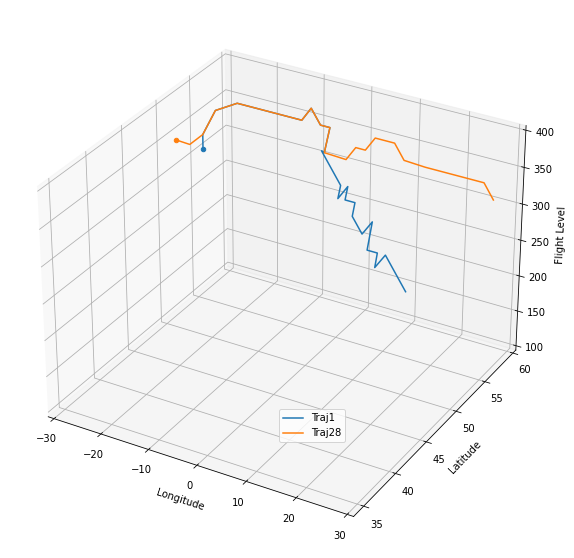

In [29]:
# Before collisions being resolved 
visualize_two_point_trajs(point_trajs_with_collisions[1], point_trajs_with_collisions[28], 
                          "Traj1", "Traj28", label_loc=(0.5, 0.2))
plt.savefig("traj_collision.png", dpi=500)

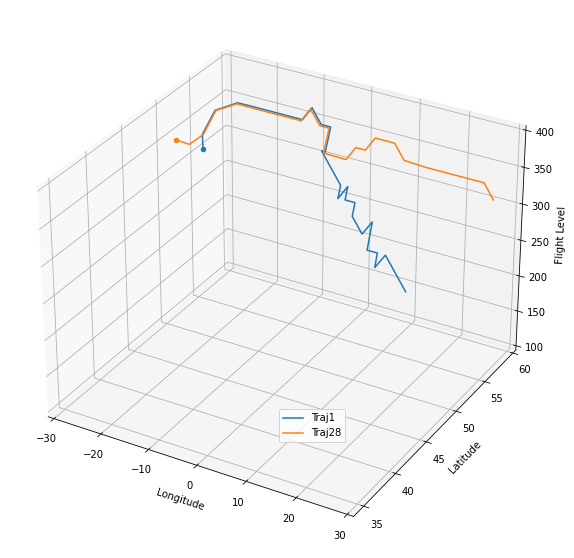

In [30]:
# Before collisions being resolved 
visualize_two_point_trajs(point_trajs[1], point_trajs[28], 
                          "Traj1", "Traj28", label_loc=(0.5, 0.2))
plt.savefig("traj_no_collision.png", dpi=500)

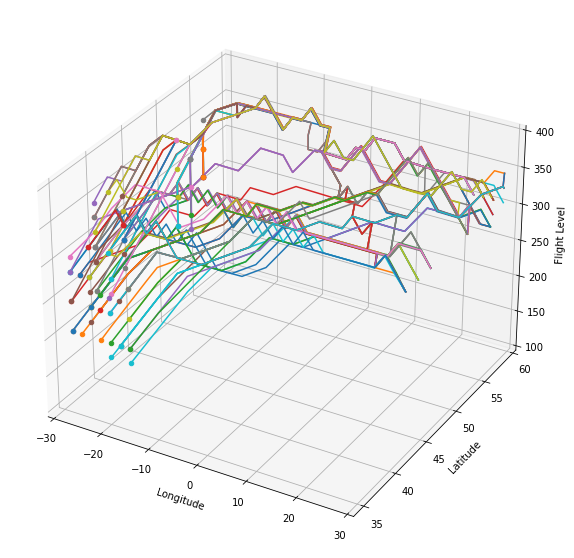

In [31]:
# 100 Flights (the dots are the starting points)
visualize_point_trajs(point_trajs)
plt.savefig("all_traj_no_collision.png", dpi=500)

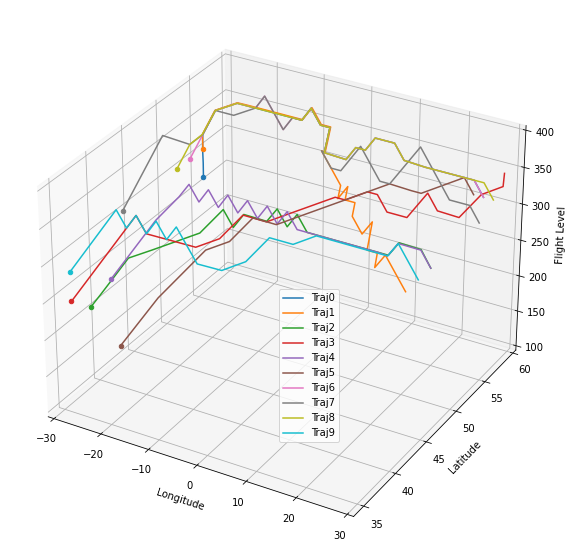

In [32]:
# First 10 Flights (the dots are the starting points)
visualize_point_trajs(point_trajs[0:10], label=True, label_loc=(0.5, 0.2))
plt.savefig("10_traj_no_collision.png", dpi=500)

#  Time as the Cost (Shortest Path is now Fastest Path)

In [33]:
dist_matrix_time, predecessors_time = shortest_path(csgraph=time_matrix_26_neighbors, 
                                                    directed=True, return_predecessors=True)

In [34]:
def get_flight_time_from_path(path, time_matrix):
    """
    Return flight_time (unit in min) given the PATH and TIME_MATRIX.
    """
    return get_delta_C_from_path(path, time_matrix)

In [35]:
def get_delta_C_traj_time_matrix(start_time, start_voxel, end_long, end_lat, weight_matrix, time_matrix, predecessors):
    """
    Another version of `get_delta_C_traj` which uses flight time as the cost for shortest path.
    But still returns delta_C in Kelvin. 
    """
    min_flight_time = np.inf
    min_path = []
    for i in range(100, 420, 20):
        end_voxel = get_voxel_from_point(end_long, end_lat, i)
        path = get_path(predecessors, start_voxel, end_voxel)
        flight_time = get_flight_time_from_path(path, time_matrix)
        if flight_time < min_flight_time:
            min_flight_time = flight_time
            min_path = path
    delta_C = get_delta_C_from_path(min_path, weight_matrix)
    time = start_time
    traj = [[time, min_path[0]]] # minute, voxel
    for i in range(len(min_path) - 1):
        time += time_matrix[min_path[i]][min_path[i+1]]
        traj.append([time, min_path[i+1]])
    return delta_C, traj

def get_delta_C_traj_one_flight_time_matrix(flight_number):
    """
    Another version of `get_delta_C_traj_one_flight` which uses flight time as the cost for shortest path.
    But still returns delta_C in Kelvin. 
    """
    # 6 AM
    data = flights.loc[flight_number]
    start_time, start_fl, start_long, start_lat, end_long, end_lat = data[1], data[2], data[3], data[4], data[5], data[6]
    start_time = time_to_min(start_time)
    start_voxel = get_voxel_from_point(start_long, start_lat, start_fl)
    min_delta_C_6am, traj_6am = get_delta_C_traj_time_matrix(start_time, start_voxel, 
                                                             end_long, end_lat, 
                                                             weight_matrix_26_neighbors_6am, 
                                                             time_matrix_26_neighbors, predecessors_time)
    if traj_6am[-1][0] < 180:
        # print("Flight ended before 9 AM")
        return min_delta_C_6am, traj_6am
    for i, (time, voxel) in enumerate(traj_6am):
        if time >= 180:
            traj_6am = traj_6am[:i]
            path_6am = [voxel for _, voxel in traj_6am]
            min_delta_C_6am = get_delta_C_from_path(path_6am, weight_matrix_26_neighbors_6am)
            break
    # 12 PM
    start_time = traj_6am[-1][0]
    start_voxel = traj_6am[-1][1]
    min_delta_C_12pm, traj_12pm = get_delta_C_traj_time_matrix(start_time, start_voxel, 
                                                               end_long, end_lat, 
                                                               weight_matrix_26_neighbors_12pm, 
                                                               time_matrix_26_neighbors, predecessors_time)
    traj_12pm = traj_12pm[1:]
    if traj_12pm[-1][0] < 540:
        # print("Flight ended before 3 PM")
        return min_delta_C_6am + min_delta_C_12pm, traj_6am + traj_12pm
    for i, (time, voxel) in enumerate(traj_12pm):
        if time >= 540:
            traj_12pm = traj_12pm[:i]
            path_12pm = [voxel for _, voxel in traj_12pm]
            min_delta_C_12pm = get_delta_C_from_path(path_12pm, weight_matrix_26_neighbors_12pm)
            break
    # 6 PM
    start_time = traj_12pm[-1][0]
    start_voxel = traj_12pm[-1][1]
    min_delta_C_6pm, traj_6pm = get_delta_C_traj_time_matrix(start_time, start_voxel, 
                                                             end_long, end_lat, 
                                                             weight_matrix_26_neighbors_6pm, 
                                                             time_matrix_26_neighbors, predecessors_time)
    traj_6pm = traj_6pm[1:]
    # print("Flight ended after 3 PM")
    return min_delta_C_6am + min_delta_C_12pm + min_delta_C_6pm, traj_6am + traj_12pm + traj_6pm

def get_delta_C_traj_flights_time_matrix():
    """
    Another version of `get_delta_C_traj_flights` which uses flight time as the cost for shortest path.
    But still returns delta_C in Kelvin. 
    """
    total_delta_C = 0
    trajs = []
    for i in range(100):
        delta_C, traj = get_delta_C_traj_one_flight_time_matrix(i)
        total_delta_C += delta_C
        trajs.append(traj)
    return total_delta_C, trajs

In [36]:
def get_total_flight_time(trajs):
    """
    Return total flight time in minutes given trajectories of the flights TRAJS.
    """
    total_time = 0
    for traj in trajs:
        total_time += traj[-1][0] - traj[0][0]
    return total_time

In [37]:
total_delta_C_time_matrix, trajs_time_matrix = get_delta_C_traj_flights_time_matrix()
print("Total Cost for 100 Flights (for fastest path):", total_delta_C_time_matrix, "* 10^-12 K")
print("Total Cost for 100 Flights (for shortest, greenest path):", total_delta_C, "* 10^-12 K")
saved_cost_percentage = (total_delta_C_time_matrix - total_delta_C) / total_delta_C_time_matrix * 100
print("We save " + str(np.round(saved_cost_percentage, 3)) + "% of the cost by considering climate effects")

Total Cost for 100 Flights (for fastest path): 149304.14234664975 * 10^-12 K
Total Cost for 100 Flights (for shortest, greenest path): 113039.58067816428 * 10^-12 K
We save 24.289% of the cost by considering climate effects


In [38]:
total_flight_fastest = get_total_flight_time(trajs_time_matrix)
total_flight_greenest = get_total_flight_time(point_trajs)
print("Total flight time for fastest path:", total_flight_fastest, "minutes")
print("Total flight time for greenest path:", total_flight_greenest, "minutes")
print("We will delay", (total_flight_greenest - total_flight_fastest) / 100, "minutes per flight")

Total flight time for fastest path: 37885.54134775811 minutes
Total flight time for greenest path: 42316.92594169992 minutes
We will delay 44.313845939418094 minutes per flight


# Visual Comparisons

In [39]:
point_trajs_time_matrix = [voxel_traj_to_points(traj) for traj in trajs_time_matrix]

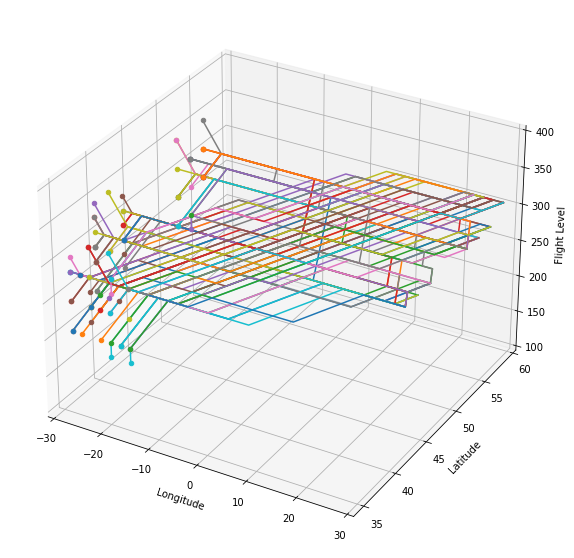

In [40]:
# 100 Fastest Flights (the dots are the starting points)
visualize_point_trajs(point_trajs_time_matrix)
plt.savefig("all_traj_fastest.png", dpi=500)

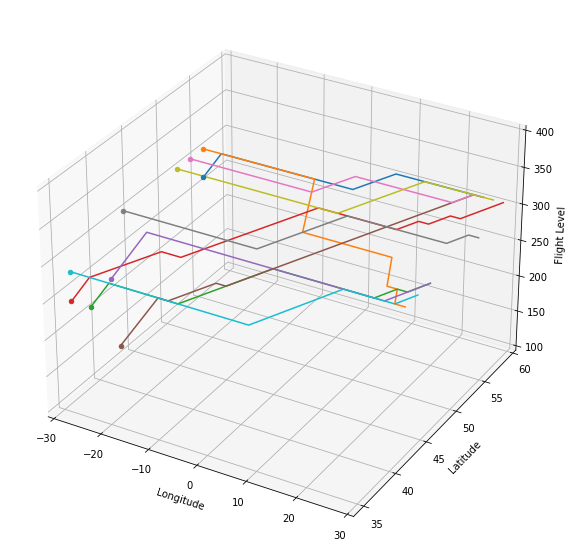

In [41]:
# First 10 Fastest Flights (the dots are the starting points)
visualize_point_trajs(point_trajs_time_matrix[0:10])
plt.savefig("10_traj_fastest.png", dpi=500)

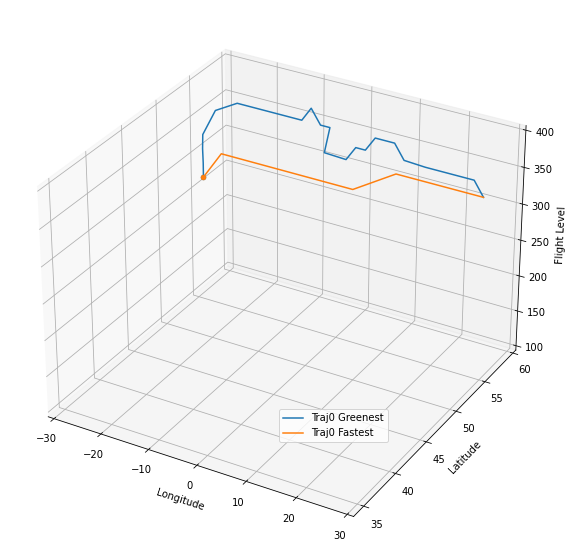

In [42]:
# Comparison between Green and Fast
visualize_two_point_trajs(point_trajs[0], point_trajs_time_matrix[0], 
                          "Traj0 Greenest", "Traj0 Fastest", label_loc=(0.5, 0.2))
plt.savefig("traj0_green_fast_compare.png", dpi=500)

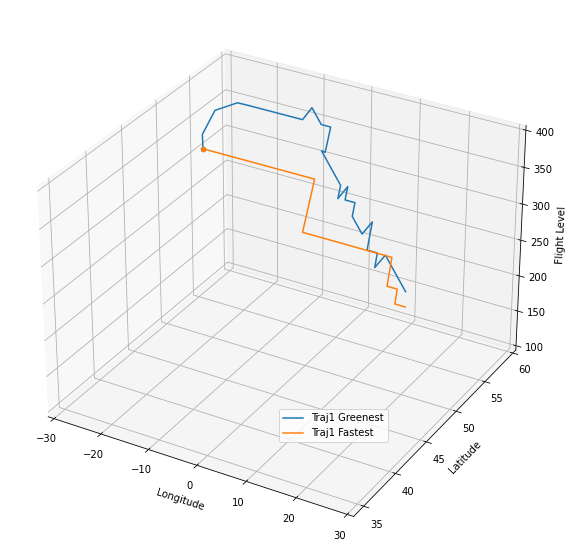

In [43]:
# Comparison between Green and Fast
visualize_two_point_trajs(point_trajs[1], point_trajs_time_matrix[1], 
                          "Traj1 Greenest", "Traj1 Fastest", label_loc=(0.5, 0.2))
plt.savefig("traj1_green_fast_compare.png", dpi=500)

# Save Trajectories to Excel Sheets

In [44]:
def point_trajs_to_df(point_trajs):
    """
    Return a DataFrame of the point trajectories.
    """
    df = pd.DataFrame(columns=["Flight Number", "Time", "Longitude", "Latitude", "Flight Level"])
    for flight_number, point_traj in enumerate(point_trajs):
        for time, point in point_traj:
            dict = {"Flight Number": flight_number, "Time": min_to_time(time),
                    "Longitude": point[0], "Latitude": point[1], "Flight Level": point[2]}
            df = df.append(dict, ignore_index = True)
    return df

In [45]:
df = point_trajs_to_df(point_trajs)

In [46]:
df.to_excel("trajectories.xlsx")